https://arxiv.org/pdf/1709.01507v3.pdf

### SENet

#### Squeeze and Excitation block

Squeeze and Excitation block(SE block)は次の図のような構造を持っています。

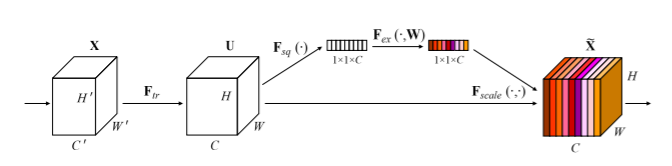

このSE blockをResNetなどに挿入することでSE-〇〇Netが構成されます。
また、これらをまとめてSE-Netと呼びます。

入力を$\boldsymbol{X}$として、構造を確認していきます。
まず、任意の変換$\boldsymbol{F}_{tr}:\boldsymbol{X}(H'×W'×C')→\boldsymbol{U}(H×W×C)$を考えます。この変換は例えば単にconvolutionであったり、Inceptionであったりします。  

#### squeeze
$\boldsymbol{U}$は最初にチャンネル毎に画像全体(H×W領域)の平均値などが計算することにより、チャンネル数分の数値に変換されます。  
$\boldsymbol{U}$のチャンネル$C$の特徴マップを$\boldsymbol{u}_C$としたとき、変換後の$\boldsymbol{z}(1×1×C)$のチャンネル$C$の成分は、
$$
z_c=\boldsymbol{F}_{sq}(\boldsymbol{u}_C)=\frac{1}{H×W}\sum_{i=1}^H\sum_{j=1}^Wu_c(i,j)
$$
と書くことができます。

#### excitation
squeezeにより得られた数値を線形変換し、sigmoidで0~1に変換します。
このチャンネル数分の数値をもとの特徴マップ$\boldsymbol{U}$に掛け合わせます。

線形変換部分では1つ目の変換(重み$\boldsymbol{W}_1(\frac{C}{r}×C)$)でチャンネル数を$C/r$に減衰させ、2つ目の変換(重み$\boldsymbol{W}_2(C×\frac{C}{r})$)でチャンネル数を元の$C$に戻します。その後、sigmoid関数$\sigma$により変換を行います。1つ目の線形変換後はReLU関数$\delta$を適用します。これらの変換で得られる$\boldsymbol{s}(1×1×C)$は、
$$
\boldsymbol{s}=\boldsymbol{F}_{ex}(\boldsymbol{z},\boldsymbol{W})=\sigma{(g(\boldsymbol{z},\boldsymbol{W}))}=
\sigma{(\boldsymbol{W}\delta(\boldsymbol{W}_1\boldsymbol{z}))}
$$
と表すことができます。  
最後に、$\boldsymbol{U}$のチャンネル毎に対応する$\boldsymbol{s}$の成分を掛け合わせていきます。この変換で得られる出力を$\tilde{X}=[\tilde{x}_1,\cdots,\tilde{x}_C]$とすると、
$$
\tilde{x}_C=\boldsymbol{F}_{scale}(\boldsymbol{u}_C,s_C)=s_C・\boldsymbol{u}_C
$$
と書くことができます。

#### SENet

たとえば、$\boldsymbol{F}_{tr}$としてInceptionを使えば、次の図のような構造となります。

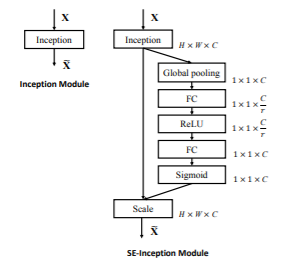


これを、SE-Inceptionと呼びます。
また、$\boldsymbol{F}_{tr}$をResNetとすれば、

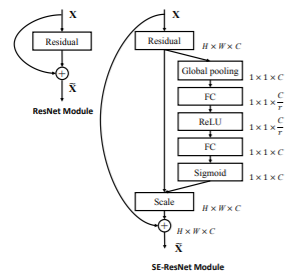

図のようなSE-ResNetとなります。

構造の詳細は次の表のようになります。
$[a,b]$は2つの線形変換の出力するチャンネル数となります。

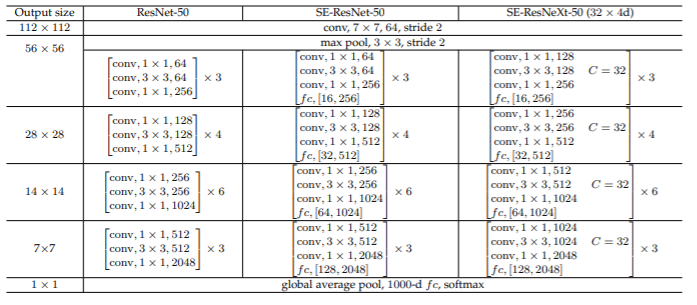

#### 学習
SGDでmomentumは0.9、学習率は0.6とし30エポックごとに0.1を掛けて減衰させていきます。  
入力はInceptionであれば299×299、他のものは224×224です。

#### 実装
実装はSEResNeXt-50について行います。
以前実装したものにSEBlockを追加するだけです。

In [17]:
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Add
from keras.layers.merge import concatenate
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler
from keras.datasets import cifar10
import numpy as np
import cv2

In [45]:
class SE_Block(Model):
    def __init__(self, in_channels, r=16):
        super().__init__()
        self.pool = GlobalAveragePooling2D()
        self.fc1 = Dense(int(in_channels/r))
        self.relu = Activation("relu")
        self.fc2 = Dense(in_channels, activation='sigmoid')
    
    def call(self, x):
        out = self.pool(x)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out *= x
        return out

In [7]:
class conv_bn_relu(Model):
    def __init__(self, out_channels, kernel_size=1, strides=1, groups=1):
        super(conv_bn_relu, self).__init__()
        self.conv = Conv2D(out_channels, kernel_size=kernel_size, strides=strides, groups=groups, padding='same')
        self.bn = BatchNormalization()
        self.relu = Activation("relu")

    def call(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)

        return x

In [46]:
class se_resnext_block(Model):
    def __init__(self, out_channels, groups=1, block_num=0, layer_num=0):
        super(se_resnext_block, self).__init__(name='block'+'_'+str(block_num)+'_'+str(layer_num))
        block_name = '_'+str(block_num)+'_'+str(layer_num)
        # shortcutとstrideの設定
        if (layer_num == 0):
            # 最初のresblockは(W､ H)は変更しないのでstrideは1にする
            if (block_num==1):
                stride = 1
            else:
                stride = 2
            self.conv_sc = conv_bn_relu(out_channels, kernel_size=1, strides=stride, groups=1)
        else:
            stride = 1
        
        mid_channels=out_channels/2
        
        self.conv1 = conv_bn_relu(out_channels=mid_channels, kernel_size=1, strides=1, groups=groups)
        self.conv2 = conv_bn_relu(out_channels=mid_channels, kernel_size=3, strides=stride, groups=32)
        self.conv3 = conv_bn_relu(out_channels=out_channels, kernel_size=1, strides=1, groups=1)
        
        self.se = SE_Block(in_channels=out_channels)
        
        self.add = Add(name='add'+block_name)
        
    def call(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        
        out = self.se(out)

        if K.int_shape(x) != K.int_shape(out):
            shortcut = self.conv_sc(x)
        else:
            shortcut = x
        
        out = self.add([out, shortcut])
        return out

In [21]:
class SEResNeXt(Model):
    def __init__(self, layers, num_classes=10):
        super().__init__()
        self._layers = []

        # 入力層
        self._layers += [
            conv_bn_relu(out_channels = 64, kernel_size = 7, strides = 2),
            MaxPooling2D(pool_size=3, strides=2, padding='same')
        ]

        # Residualブロック
        for b in np.arange(len(layers)):
            self._layers += [se_resnext_block(out_channels=256*(2**b), block_num=b+1, layer_num=i) for i in range(layers[b])]

        # 出力層
        self._layers += [
            GlobalAveragePooling2D(name='pool_output'),
            Dense(num_classes, activation='softmax', name='output')
        ]
    
    def call(self, x):
        for layer in self._layers:
            x = layer(x)
        return x

In [22]:
model = SEResNeXt(layers=[3,4,6,3])
model.build((None, 224, 224, 3))  # build with input shape.
dummy_input = Input(shape=(224, 224, 3))  # declare without batch demension.
model_summary = Model(inputs=[dummy_input], outputs=model.call(dummy_input))
model_summary.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv_bn_relu_55 (conv_bn_rel (None, 112, 112, 64)      9728      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
block_1_0 (se_resnext_block) (None, 56, 56, 256)       74256     
_________________________________________________________________
block_1_1 (se_resnext_block) (None, 56, 56, 256)       81168     
_________________________________________________________________
block_1_2 (se_resnext_block) (None, 56, 56, 256)       81168     
_________________________________________________________________
block_2_0 (se_resnext_block) (None, 28, 28, 512)      

In [23]:
epochs = 40
initial_lrate = 0.01

def decay(epoch, steps=100):
    initial_lrate = 0.01
    drop = 0.9
    epochs_drop = 10
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

sgd = SGD(lr=initial_lrate, momentum=0.9, nesterov=False)
lr_sc = LearningRateScheduler(decay, verbose=1)

model = SEResNeXt(layers=[3,4,6,3])
model.compile(loss=['categorical_crossentropy'], optimizer=sgd, metrics=['accuracy'])

In [5]:
model = SE_Block(in_channels=3, mid_channels=10)
model.build((None, 299, 299, 3))  # build with input shape.
dummy_input = Input(shape=(299, 299, 3))  # declare without batch demension.
model_summary = Model(inputs=[dummy_input], outputs=model.call(dummy_input))
model_summary.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 3)            0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 10)           40          global_average_pooling2d[0][0]   
__________________________________________________________________________________________________
activation (Activation)         (None, 10)           0           dense[0][0]                      
_______________________________________________________________________________________

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim

import pytorch_lightning as pl
from torchmetrics import Accuracy as accuracy

In [47]:
class SE_Block(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc1 = nn.Linear(in_channels, int(in_channels/16))
        self.relu = nn.ReLU(inplace=False)
        self.fc2 = nn.Linear(int(in_channels/16), in_channels)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out = self.pool(x)
        out = out.view(out.shape[0], -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        out = out.view(out.shape[0], out.shape[1], 1,1).expand_as(x)
        return out * x

In [50]:
class conv_bn_relu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1, strides=1, groups=1):
        super(conv_bn_relu, self).__init__()
        pad = int((kernel_size-1)/2)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=strides, groups=groups, padding=pad)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)

        return x

In [52]:
class se_resnext_block(nn.Module):
    def __init__(self, out_channels, groups=1, block_num=0, layer_num=0):
        super(se_resnext_block, self).__init__()
        # shortcutとstrideの設定
        if (layer_num == 0):
            self._is_change = True
            # 最初のresblockは(W､ H)は変更しないのでstrideは1にする
            if (block_num==1):
                stride = 1
                in_channels = 64
            else:
                stride = 2
                in_channels = int(out_channels//2)
            
            self.conv_sc = conv_bn_relu(in_channels, out_channels, kernel_size=1, strides=stride)
        else:
            self._is_change = False
            stride = 1
            in_channels = out_channels
        
        mid_channels=int(out_channels/2)
        
        
        self.conv1 = conv_bn_relu(in_channels=in_channels, out_channels=mid_channels, kernel_size=1, strides=1, groups=1)
        self.conv2 = conv_bn_relu(in_channels=mid_channels, out_channels=mid_channels, kernel_size=3, strides=stride, groups=groups)
        self.conv3 = conv_bn_relu(in_channels=mid_channels, out_channels=out_channels, kernel_size=1, strides=1, groups=1)
        
        self.se = SE_Block(in_channels=out_channels)
        
    def forward(self, x):
        shortcut = x
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        
        out = self.se(out)

        if self._is_change:
            shortcut = self.conv_sc(shortcut)
        
        out += shortcut
        return out

In [55]:
class SEResNeXt(nn.Module):
    def __init__(self, layer_nums, groups, num_classes=10):
        super(SEResNeXt, self).__init__()
        
        self.conv1 = nn.Sequential(*[conv_bn_relu(in_channels=3, out_channels=64, kernel_size=7, strides=2, groups=1),
                                     nn.MaxPool2d(kernel_size=3, stride=2,padding=1)])
        
        layers = []
        for b in range(len(layer_nums)):
            layers += [se_resnext_block(out_channels=256*(2**b), groups=groups, block_num=b+1, layer_num=i) for i in range(layer_nums[b])]
        
        self.resnext = nn.Sequential(*layers)

        self.fc = nn.Sequential(*[nn.AdaptiveAvgPool2d((1,1))])        
        self.linear = nn.Linear(in_features=2048, out_features=num_classes)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.resnext(out)
        out = self.fc(out)
        out = out.view(out.shape[0], -1)
        out = self.linear(out)
        
        return out

In [57]:
from torchsummary import summary

summary(SEResNeXt(layer_nums=[3,4,6,3], groups=32), (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
      conv_bn_relu-4         [-1, 64, 112, 112]               0
         MaxPool2d-5           [-1, 64, 56, 56]               0
            Conv2d-6          [-1, 128, 56, 56]           8,320
       BatchNorm2d-7          [-1, 128, 56, 56]             256
              ReLU-8          [-1, 128, 56, 56]               0
      conv_bn_relu-9          [-1, 128, 56, 56]               0
           Conv2d-10          [-1, 128, 56, 56]           4,736
      BatchNorm2d-11          [-1, 128, 56, 56]             256
             ReLU-12          [-1, 128, 56, 56]               0
     conv_bn_relu-13          [-1, 128, 56, 56]               0
           Conv2d-14          [-1, 256,

         Sigmoid-125                  [-1, 512]               0
        SE_Block-126          [-1, 512, 28, 28]               0
se_resnext_block-127          [-1, 512, 28, 28]               0
          Conv2d-128          [-1, 256, 28, 28]         131,328
     BatchNorm2d-129          [-1, 256, 28, 28]             512
            ReLU-130          [-1, 256, 28, 28]               0
    conv_bn_relu-131          [-1, 256, 28, 28]               0
          Conv2d-132          [-1, 256, 28, 28]          18,688
     BatchNorm2d-133          [-1, 256, 28, 28]             512
            ReLU-134          [-1, 256, 28, 28]               0
    conv_bn_relu-135          [-1, 256, 28, 28]               0
          Conv2d-136          [-1, 512, 28, 28]         131,584
     BatchNorm2d-137          [-1, 512, 28, 28]           1,024
            ReLU-138          [-1, 512, 28, 28]               0
    conv_bn_relu-139          [-1, 512, 28, 28]               0
AdaptiveAvgPool2d-140            [-1, 51

            ReLU-252          [-1, 512, 14, 14]               0
    conv_bn_relu-253          [-1, 512, 14, 14]               0
          Conv2d-254         [-1, 1024, 14, 14]         525,312
     BatchNorm2d-255         [-1, 1024, 14, 14]           2,048
            ReLU-256         [-1, 1024, 14, 14]               0
    conv_bn_relu-257         [-1, 1024, 14, 14]               0
AdaptiveAvgPool2d-258           [-1, 1024, 1, 1]               0
          Linear-259                   [-1, 64]          65,600
            ReLU-260                   [-1, 64]               0
          Linear-261                 [-1, 1024]          66,560
         Sigmoid-262                 [-1, 1024]               0
        SE_Block-263         [-1, 1024, 14, 14]               0
se_resnext_block-264         [-1, 1024, 14, 14]               0
          Conv2d-265         [-1, 1024, 14, 14]       1,049,600
     BatchNorm2d-266         [-1, 1024, 14, 14]           2,048
            ReLU-267         [-1, 1024,

In [58]:
class SEResNeXtTrainer(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = SEResNeXt(layer_nums=[3,4,6,3], groups=32)
        
    def forward(self, x):
        x = self.model(x)
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch 
        #x, y = x.to(device), y.to(device)
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        return {'loss': loss, 'y_hat':y_hat, 'y':y, 'batch_loss': loss.item()*x.size(0)}
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        #x, y = x.to(device), y.to(device)
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        return {'y_hat':y_hat, 'y':y, 'batch_loss': loss.item()*x.size(0)}
    
    def test_step(self, batch, batch_nb):
        x, y = batch
        #x, y = x.to(device), y.to(device)
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        y_label = torch.argmax(y_hat, dim=1)
        acc = accuracy()(y_label, y)
        return {'test_loss': loss, 'test_acc': acc}
    
    def training_epoch_end(self, train_step_output):
        y_hat = torch.cat([val['y_hat'] for val in train_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in train_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in train_step_outputs]) / y_hat.size(0)
        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy()(preds, y)
        self.log('train_loss', epoch_loss, prog_bar=True, on_epoch=True)
        self.log('train_acc', acc, prog_bar=True, on_epoch=True)
        
        print('---------- Current Epoch {} ----------'.format(self.current_epoch + 1))
        print('train Loss: {:.4f} train Acc: {:.4f}'.format(epoch_loass, acc))
    
    def validation_epoch_end(self, val_step_outputs):
        y_hat = torch.cat([val['y_hat'] for val in val_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in val_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in val_step_outputs]) / y_hat.size(0)
        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy()(preds, y)
        self.log('val_loss', epoch_loss, prog_bar=True, on_epoch=True)
        self.log('val_acc', acc, prog_bar=True, on_epoch=True)
        
        print('valid Loss: {:.4f} valid Acc: {:.4f}'.format(epoch_loss, acc))
    
    # New: テストデータに対するエポックごとの処理
    def test_epoch_end(self, test_step_outputs):
        y_hat = torch.cat([val['y_hat'] for val in test_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in test_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in test_step_outputs]) / y_hat.size(0)
        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy()(preds, y)
        self.log('test_loss', epoch_loss, prog_bar=True, on_epoch=True)
        self.log('test_acc', acc, prog_bar=True, on_epoch=True)
        
        print('test Loss: {:.4f} test Acc: {:.4f}'.format(epoch_loss, acc))
        
    def configure_optimizers(self):
        optimizer = optim.SGD(self.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
        return {'optimizer': optimizer, 'lr_scheduler': scheduler}